In [ ]:
# CPU-only stack (no CUDA, no xformers)
!pip -q uninstall -y xformers torch torchvision torchaudio peft || true

# Matching, CPU wheels (PyTorch 2.4 series)
!pip -q install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0

# Core libs (pinned) — hub pinned >=0.33.5 to satisfy Gradio
!pip -q install diffusers==0.30.2 transformers==4.43.3 accelerate==0.33.0 \
  safetensors==0.4.3 pillow==10.4.0 huggingface-hub==0.34.1

import os, time
print("✅ Installed. Restarting runtime…")
time.sleep(0.8)
os.kill(os.getpid(), 9)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.

In [ ]:
from datetime import datetime
import os
from PIL import Image
import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler

DEVICE = "cpu"
DTYPE = torch.float32  # SDXL on CPU should run in fp32

def set_reproducible(seed: int):
    torch.manual_seed(seed)
    return torch.Generator(device=DEVICE).manual_seed(seed)

def pick_scheduler(name: str, pipe):
    name = (name or "").lower()
    if name in {"dpmpp", "dpmpp_2m"}:
        return DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras=True)
    if name in {"euler_a", "euler-ancestral"}:
        return EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    return pipe.scheduler  # default

def prepare_pipe(model_id: str, scheduler_name: str = "dpmpp_2m"):
    pipe = StableDiffusionXLPipeline.from_pretrained(
        model_id,
        torch_dtype=DTYPE,
        use_safetensors=True,
        add_watermarker=False,
    )
    pipe.scheduler = pick_scheduler(scheduler_name, pipe)
    pipe = pipe.to(DEVICE)
    pipe.enable_vae_slicing()
    pipe.enable_vae_tiling()
    return pipe

def sanitize_wh(x: int) -> int:
    # SDXL requires multiples of 8
    return int(round(x / 8) * 8)

def save_image(img: Image.Image, outdir: str, stem: str) -> str:
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, f"{stem}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    img.save(path)
    return path

print("Running on:", DEVICE, "| dtype:", DTYPE)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Running on: cpu | dtype: torch.float32


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

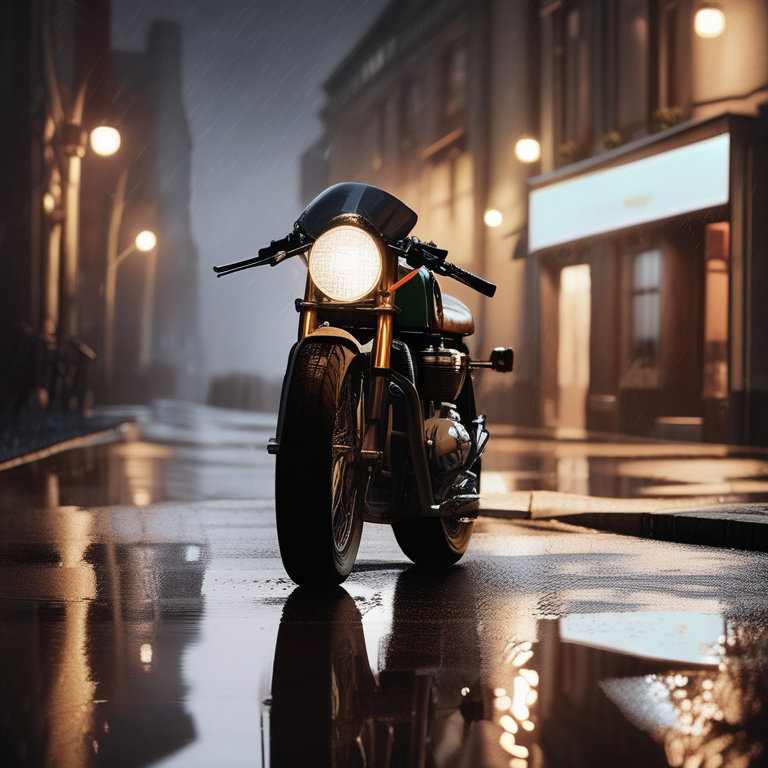

Saved to: sdxl_out_cpu/sdxl_base_seed12345_g6.5_s28_w768_h768_20250824_171020.png


In [ ]:
prompt = "Cinematic shot of a cafe racer motorcycle on a rainy street at night, reflections, broken lights"
negative_prompt = "motion blur, blown highlights, low quality, chromatic aberration, watermark"
seed = 12345
steps = 28
guidance_scale = 6.5
width, height = 768, 768
scheduler_name = "dpmpp_2m" # or "euler_a" or "default"

#Run
g = set_reproducible(seed)
w, h = sanitize_wh(width), sanitize_wh(height)

base_id = "stabilityai/stable-diffusion-xl-base-1.0"
base = prepare_pipe(base_id, scheduler_name)

out = base(
    prompt=prompt,
    negative_prompt=negative_prompt or None,
    num_inference_steps=int(steps),
    guidance_scale=float(guidance_scale),
    width=w, height=h,
    generator=g,
)
img = out.images[0]
save_path = save_image(img, "sdxl_out_cpu", f"sdxl_base_seed{seed}_g{guidance_scale}_s{steps}_w{w}_h{h}")
display(img)
print("Saved to:", save_path)
